In [3]:
###### import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
import numpy as np

# Physical constant
e = 1.6e-19 #[C] electron charge 
M_i = 32*1.6605e-27 #[kg] ion mass
m = 9.11e-31 #[kg] electron mass
k = 1.38e-23 #[m2 kg /s2 K] Boltzmann constant

# Experimental constant
p = 10e-3*133.33 #[mTorr to Pa]
R = 30e-3 #[m] plasma half-width
L = 330e-3 #[m] chamber length
Tg = 300 #[K] gas temperature
R_0 = 25e-3 #[m] chosen normalization length
gamma = 20 # electron-ion temperature ratio Te/Ti
n_g = p/k/Tg #[m-3] neutral gas density
print("n_g = {}(m-3)".format(n_g))

n_g = 3.220531400966184e+20(m-3)


### 단위체크!!!

1. R은 정해진다. (이 논문에서 보고자하는게 R이 정해진 상태에서 $\alpha,n_{e0}$가 어떻게 되어야 하는지임, 거꾸로 $\alpha,n_{e0}$가 주어지면 R도 찾을수있을거같음)
2. R이 정해졌고 Boundary Condition (${\Gamma_e(R) = 0, n_e(R) = 0}$)을 만족해야한다. solve_bvp 사용할것
3. BC만족하는 Te를 찾는다. (여러개려나?)
4. Te도 나왔으니 $\nu_L$은 특정 RL값이 주어지면 결정된다.

초기 주어진값: R <br>
미지수 : E,N,U,V,W,Phi

In [4]:
class fluid_model():
    
    def __init__(self, n_e0, B_0, Te, alpha_0, gamma = 20):
        self.n_e0 = n_e0
        self.B_0 = B_0 #[T] magnetic field
        self.Te = Te #[eV] electron temperature
        self.Ti = Te/gamma # gamma = electron-ion temperature ratio Te/Ti
        self.alpha_0 = alpha_0
        print("n_e0 : ",n_e0)
        
    def calculation(self, eqn, X):
        E = eqn[0]
        N = eqn[1]
        U = eqn[2]
        V = eqn[3]
        W = eqn[4]
        Phi = eqn[5]

        K_iz =  2.34e-15*self.Te**1.03*np.exp(-12.29/self.Te) #[m3/s]
        K_att = 1.07e-15*self.Te**-1.391*np.exp(-6.26/self.Te) #[m3/s]
        K_rec = 5.2e-14*(0.026/self.Ti)**0.44 #[m3/s]
        nu_i = 3.95e-16*n_g #[s-1]
        nu_e = 4.7e-14*self.Te**0.5*n_g #[s-1]
        nu_n = 3.95e-16*n_g #[s-1]
        
        w_ce = e*self.B_0/m
        Di = e*self.Ti/(M_i*nu_i)
        nu_L = 2*Di/(R*L)*(1+self.Te/self.Ti)**0.5
        
        G = n_g/self.n_e0
        Cs = np.sqrt(e*self.Te/M_i)
        A_i = self.n_e0*R_0*K_iz/Cs
        A_a = self.n_e0*R_0*K_att/Cs
        B_i = self.n_e0*R_0*K_rec/Cs
        C_i = R_0*nu_i/Cs
        C_e = R_0*nu_e/Cs
        C_n = R_0*nu_n/Cs
        Omega = R_0*w_ce/Cs 
        Epsilon_i = gamma #Te/Ti는 설정값으로줌
        Epsilon_n = gamma #Te/Tn, Ti=Tn
        Zeta = 1 #M_i/M_n, Mi=Mn
        D = R_0*nu_L/Cs
        Del = (A_i+A_a)*G+C_e
        Delta = Del*(m/M_i)*(1+Omega**2/Del**2)
        
        M = np.array([[V, 0, 0, E, 0, 0],
                      [U, U, (E+N), 0, 0, 0],
                      [0, W, 0, 0, N, 0],
                      [1, 0, 0, 0, 0, E],
                      [1/Epsilon_i+U**2, 1/Epsilon_i+U**2, 2*(E+N)*U, 0, 0, -(E+N)],
                      [0, Zeta/Epsilon_n+W**2, 0, 0, 2*N*W, Zeta*N]])

        RHS = np.array([(A_i-A_a)*G*E-D*(E+N),
                        A_i*G*E-B_i*(E+N)*N-D*(E+N),
                        A_a*G*E-B_i*(E+N)*N,
                        -Delta*E*V,
                        -C_i*(E+N)*U,
                        -C_n*N*W])
        result = np.linalg.solve(M,RHS)
        return result
    
    def integration(self,Normal_length):
        x0 = [1, 1*self.alpha_0, 0, 0, 0, 0] #E, N, U, V, W, Phi
        self.X = np.linspace(0,Normal_length,1000)
        

        ans = odeint(self.calculation, x0, self.X)
        self.sol_E = ans[:,0]
        self.sol_N = ans[:,1]
        self.sol_I = ans[:,0]+ans[:,1]
        self.sol_U = ans[:,2]
        self.sol_V = ans[:,3]
        self.sol_W = ans[:,4]
        self.sol_Phi = ans[:,5]

        ############# Check ###############
        self.sol_E = self.sol_E[~np.isnan(self.sol_E)]
        self.sol_N = self.sol_N[~np.isnan(self.sol_N)]
        self.sol_I = self.sol_I[~np.isnan(self.sol_I)]
        self.sol_U = self.sol_U[~np.isnan(self.sol_U)]
        self.sol_V = self.sol_V[~np.isnan(self.sol_V)]
        self.sol_W = self.sol_W[~np.isnan(self.sol_W)]
        self.sol_Phi = self.sol_Phi[~np.isnan(self.sol_Phi)]
        self.X = self.X[0:len(self.sol_E)]
        
        print('I', self.sol_I[-6:-1])
        print('E', self.sol_E[-6:-1])
        print('N', self.sol_N[-6:-1])
        print('U', self.sol_U[-6:-1])
        print('V', self.sol_V[-6:-1])
        print('W', self.sol_W[-6:-1])
        print('Phi', self.sol_Phi[-6:-1])
        print('Te',self.Te)
        
    def visualize(self,name):
        plt.figure(figsize = (8,12))
        plt.subplot(3,1,1)
        plt.title('Te : '+str(self.Te), loc='left')
        plt.plot(self.X, self.sol_I)
        plt.plot(self.X, self.sol_E)
        plt.plot(self.X, self.sol_N)
        plt.xlabel('Normalized position')
        plt.ylabel('Normalized densities')
        plt.legend(['Positive','Electron','Negative'])
        plt.grid(True)
        plt.xlim(0,)
        #plt.ylim(0,)
        
        plt.subplot(3,1,2)
        plt.plot(self.X, self.sol_Phi,'r')
        plt.xlabel('Normalized position')
        plt.ylabel('Normalized potential')
        plt.legend(['Potential'])
        plt.grid(True)
        plt.xlim(0,)
        
        plt.subplot(3,1,3)
        
        plt.plot(self.X, self.sol_U*self.sol_I)
        plt.plot(self.X, self.sol_V*self.sol_E)
        plt.plot(self.X, self.sol_W*self.sol_N)
        plt.xlabel('Normalized position')
        plt.ylabel('Normalized flux')
        plt.legend(['Positive','Electron','Negative'])
        plt.grid(True)
        plt.xlim(0,)
        #plt.ylim(0,)
        plt.savefig('result/'+str(name)+'.png')
        plt.show()

1.  $T_e$ 조절해가며 $n_e(R) <10^{-4}$ 인 $T_e$ 찾기

n_e0 :  8.856461352657006e+16
I [1.2116569  1.2115771  1.21150058 1.21142733 1.21135737]
E [0.04469535 0.04467828 0.044666   0.04465852 0.04465583]
N [1.16696154 1.16689882 1.16683457 1.16676881 1.16670154]
U [0.00278291 0.00273938 0.00269584 0.00265229 0.00260873]
V [2.47473220e-03 1.86607733e-03 1.25684066e-03 6.47224475e-04
 3.74316044e-05]
W [0.00279471 0.00277281 0.00275092 0.00272903 0.00270714]
Phi [-0.01558364 -0.01558401 -0.0155843  -0.0155845  -0.0155846 ]
Te 2.571


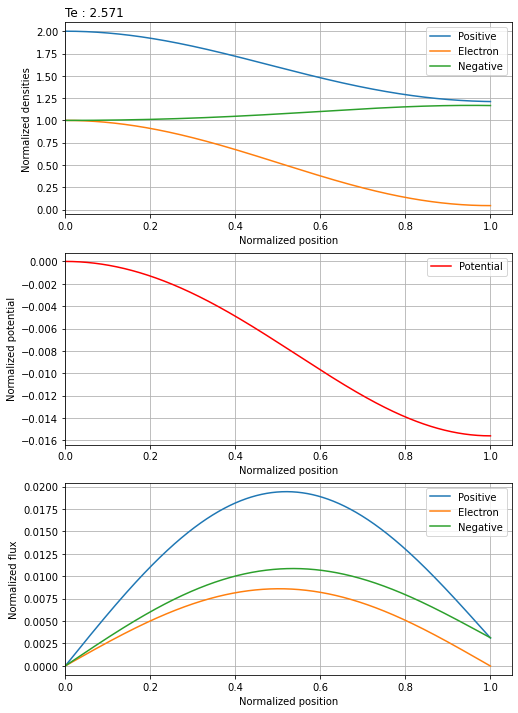

n_e0 :  8.856461352657006e+16
I [0.27163545 0.26983918 0.26802981 0.26620665 0.26436895]
E [0.05001455 0.04996612 0.04991965 0.04987511 0.04983249]
N [0.22162089 0.21987305 0.21811016 0.21633154 0.21453646]
U [0.11374307 0.11449061 0.11525416 0.11603445 0.1168323 ]
V [0.00339736 0.0032717  0.00314708 0.00302352 0.00290107]
W [0.13864536 0.13976499 0.1409124  0.14208896 0.14329613]
Phi [-0.02528978 -0.02531876 -0.02534852 -0.02537912 -0.02541062]
Te 2.49828


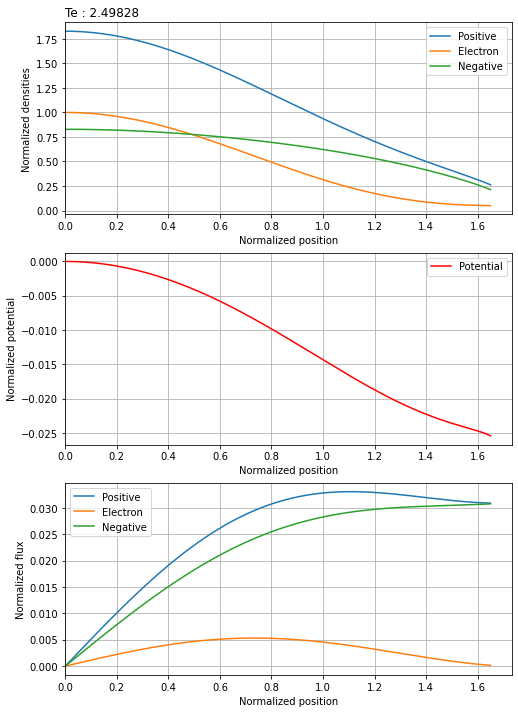

In [6]:
test_model = fluid_model(n_g*2.75e-4, 0.03, 2.571, 1)  #n_e, B, Te, alpha, gamma
test_model.integration(1)
test_model.visualize('alpha_1')

test_model = fluid_model(n_g*2.75e-4, 0.03, 2.49828, 0.828)  #n_e, B, Te, alpha, gamma
test_model.integration(1.65)
test_model.visualize(2)

### In our condition
SF6 ion mass : 146*1.6605e-27 [kg] <br>
Pressure : 1mTorr

n_e0 :  1.610265700483092e+16
I [3.34868882 3.34868505 3.34868434 3.3486867  3.34869214]
E [0.01079962 0.01079424 0.01079381 0.01079834 0.01080782]
N [3.3378892  3.33789081 3.33789053 3.33788837 3.33788432]
U [ 4.59929860e-05  2.37122203e-05  1.43127581e-06 -2.08495626e-05
 -4.31300098e-05]
V [ 0.00774262  0.00286335 -0.00201988 -0.00690031 -0.01177119]
W [ 2.10973116e-05  1.45357342e-05  7.97413079e-06  1.41255609e-06
 -5.14893521e-06]
Phi [-0.00624155 -0.00624158 -0.00624159 -0.00624156 -0.0062415 ]
Te 2.89


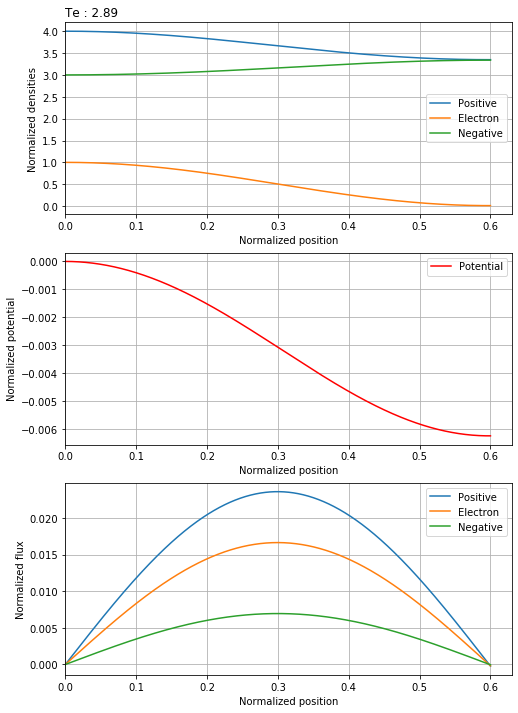

In [192]:
test_model = fluid_model(n_g*0.5e-4, 0.03, 2.89, 3)  #n_e, B, Te, alpha, gamma
test_model.integration(0.6)
test_model.visualize('alpha_3')

n_e0 :  6441062801932368.0
I [5.36658471 5.36656747 5.36655322 5.36654195 5.36653367]
E [0.0012296  0.00122043 0.00121625 0.00121704 0.00122281]
N [5.36535511 5.36534704 5.36533697 5.36532491 5.36531086]
U [0.00026786 0.00025129 0.00023472 0.00021815 0.00020157]
V [ 0.1368264   0.07895499  0.0201243  -0.03895279 -0.09755333]
W [0.00023659 0.00023341 0.00023023 0.00022705 0.00022387]
Phi [-0.0039374  -0.00393744 -0.00393746 -0.00393746 -0.00393744]
Te 3.135


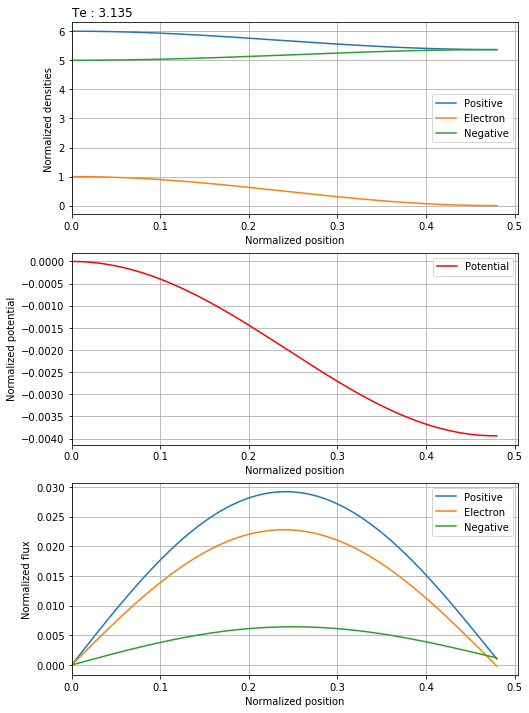

In [194]:
test_model = fluid_model(n_g*0.2e-4, 0.03, 3.135, 5)  #n_e, B, Te, alpha, gamma
test_model.integration(0.48)
test_model.visualize('alpha_5')

n_e0 :  2254371980676329.0
I [10.39944498 10.39942123 10.39940037 10.39938238 10.39936728]
E [0.00499057 0.00494092 0.00489613 0.00485621 0.00482117]
N [10.3944544  10.39448032 10.39450424 10.39452617 10.39454611]
U [ 4.55998896e-05  3.36582749e-05  2.17154664e-05  9.77159035e-06
 -2.17322730e-06]
V [0.23524996 0.21539464 0.19493986 0.17393078 0.15241756]
W [-6.73201882e-05 -6.87054955e-05 -7.00909345e-05 -7.14764932e-05
 -7.28621598e-05]
Phi [-0.00201349 -0.00201359 -0.00201368 -0.00201376 -0.00201383]
Te 3.615


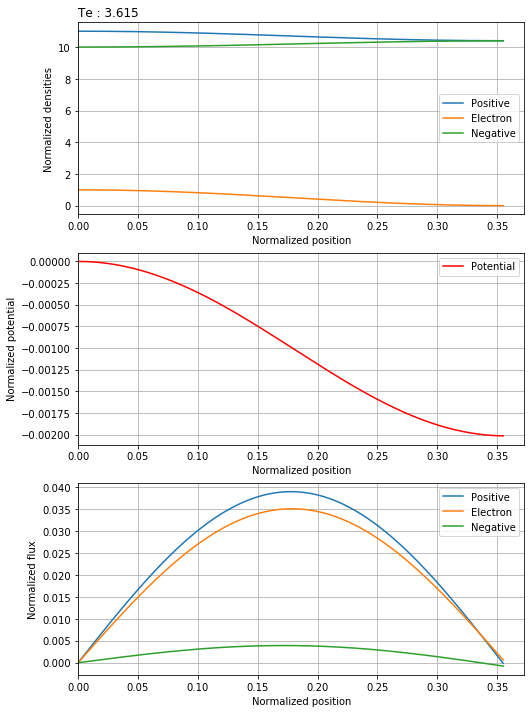

In [195]:
test_model = fluid_model(n_g*0.07e-4, 0.03, 3.615, 10)  #n_e, B, Te, alpha, gamma
test_model.integration(0.355)
test_model.visualize('alpha_10')